## Project 4: West Nile Virus Prediction
------------------------------------------------------------------------------------------------------------------------
## Part 1b. Weather EDA & Cleaning
Group 2 (Edmund, Marc, Mingzi, Rohazeanti), SG DSIF5 

## Table of Contents
- [Importing the libraries](#Importing-the-libraries)
- [Importing the datasets](#Importing-the-datasets)
- [Inspect Data](#Inspect-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

### Importing the libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

import datetime
from suntime import Sun, SunTimeException
from pytz import timezone
import pytz

import plotly.express as px
import calmap
import scipy.stats as stats

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing the datasets

In [69]:
weather = pd.read_csv('./data/weather.csv')
train = pickle.load(open('./data/train_final.pkl', 'rb'))

### Inspect Data

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8610 non-null   datetime64[ns]
 1   Species       8610 non-null   object        
 2   Trap          8610 non-null   object        
 3   Latitude      8610 non-null   float64       
 4   Longitude     8610 non-null   float64       
 5   WnvPresent    8610 non-null   int64         
 6   NumMosquitos  8610 non-null   int64         
 7   Year          8610 non-null   int64         
 8   Month         8610 non-null   int64         
 9   Day           8610 non-null   int64         
 10  Week          8610 non-null   int64         
 11  Station       8610 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 807.3+ KB


In [71]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,8610.0,41.844422,0.107076,41.644612,41.750498,41.857402,41.944869,42.017430
Longitude,8610.0,-87.695237,0.084921,-87.930995,-87.752411,-87.694991,-87.642984,-87.531635
WnvPresent,8610.0,0.053078,0.224202,0.000000,0.000000,0.000000,0.000000,1.000000
NumMosquitos,8610.0,15.683972,68.560634,1.000000,2.000000,4.000000,11.000000,2206.000000
Year,8610.0,2009.713821,2.338148,2007.000000,2007.000000,2009.000000,2011.000000,2013.000000
Month,8610.0,7.705459,1.103277,5.000000,7.000000,8.000000,9.000000,10.000000
Day,8610.0,15.485598,8.748169,1.000000,8.000000,15.000000,24.000000,31.000000
Week,8610.0,31.759930,4.694337,22.000000,28.000000,32.000000,35.000000,41.000000
Station,8610.0,1.707317,0.455021,1.000000,1.000000,2.000000,2.000000,2.000000


In [72]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [73]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.0,1.0,1.5,2.0,2.0
Tmax,2944.0,76.166101,11.461970,41.0,69.0,78.0,85.0,104.0
Tmin,2944.0,57.810462,10.381939,29.0,50.0,59.0,66.0,83.0
DewPoint,2944.0,53.457880,10.675181,22.0,46.0,54.0,62.0,75.0
ResultSpeed,2944.0,6.960666,3.587527,0.1,4.3,6.4,9.2,24.1
ResultDir,2944.0,17.494905,10.063609,1.0,7.0,19.0,25.0,36.0


### Data Cleaning

### Define functions for cleaning data

In [74]:
# Create 4 new columns: Year, Month, Day, Week from the Date column
def create_yr_day_mth(df): 
    df['Year'] = [dd.year for dd in pd.DatetimeIndex(df.Date.values)]
    df['Month'] = [dd.month for dd in pd.DatetimeIndex(df.Date.values)]
    df['Day'] = [dd.day for dd in pd.DatetimeIndex(df.Date.values)]
    df['Week'] = [dd.week for dd in pd.DatetimeIndex(df.Date.values)]
    return df

# Convert the Date into datetime format
def convert_date(df): 
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date',ascending=True,inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df

#find min and max date
def min_max_date(df, df_name):
    print("-----",df_name.upper(), "-----\n")
    print("Earliest record: ", df.Date.min(),
      "\nLatest Record: ", df.Date.max(), "\n")
    print(df['Year'].unique(),"\n")
    
def whitespace_remover(dataframe):
   
    # iterating over the columns
    for i in dataframe.columns:
         
        # checking datatype of each columns
        if dataframe[i].dtype == 'object':
             
            # applying strip function on column
            dataframe[i] = dataframe[i].map(str.strip)
        else:
             
            # if condn. is False then it will do nothing.
            pass

### Weather Dataset
- Earliest record:  2007-05-01 00:00:00 
- Latest Record:  2014-10-31 00:00:00 
- Years of record: 2007 2008 2009 2010 2011 2012 2013 2014 

In [75]:
whitespace_remover(weather)
create_yr_day_mth(weather)
convert_date(weather)
min_max_date(weather, "weather")


----- WEATHER -----

Earliest record:  2007-05-01 00:00:00 
Latest Record:  2014-10-31 00:00:00 

[2007 2008 2009 2010 2011 2012 2013 2014] 



In [76]:
# Check number of Stations
weather['Station'].unique()

array([1, 2], dtype=int64)

### Missing values 
- Missing values in this Weather dataset is represented with either an "M", "-" characters.
- There are also missing values filled in with a whitespace " " character.

In [77]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
Year           0
Month          0
Day            0
Week           0
dtype: int64

In [78]:
# Replacing missing values with np.nan
weather = weather.replace({"M": np.nan,"-": np.nan, " ": np.nan})

In [79]:
# Check null
weather.isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
Year              0
Month             0
Day               0
Week              0
dtype: int64

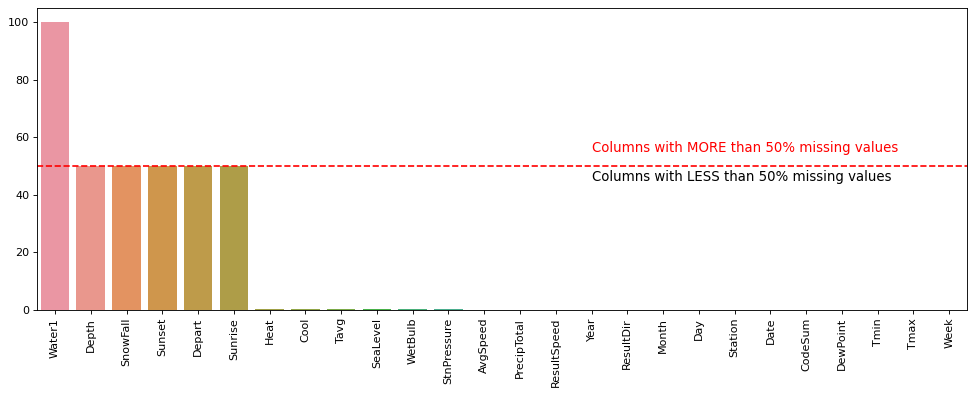

In [80]:
percent_missing = weather.isnull().sum() * 100 / len(weather)
missing_value_df = pd.DataFrame({'column_name': weather.columns,
                                'percent_missing': percent_missing})

plt.figure(figsize = (15,5), dpi = 80)
plt.xticks(rotation = 90)
#Draw horizontal line at 50%
plt.axhline(50, color = 'red', linestyle = '--')
plt.text(15, 55, 'Columns with MORE than 50% missing values', color = 'red', fontsize = 12)
plt.text(15,45, 'Columns with LESS than 50% missing values', color = 'black', fontsize = 12)
sns.barplot(data = missing_value_df, x = weather.columns, y = percent_missing,
            order = missing_value_df.sort_values('percent_missing', ascending = False).column_name);

In [81]:
# Drop the following columns with high percentage of missing values
weather.drop(columns = ['Water1', 'SnowFall', 'Depth','Depart'], inplace = True)

- We'll keep Sunset and Sunrise for now as we will be imputing the missing rows for these columns 

#### Clean `PrecipTotal`
- Trace values are represented with "T".  The term "trace" is used in two different but related contexts. The first is in weather forecasting and record-keeping of rain, snow, and other precipitation, where a trace denotes an amount of precipitation that is greater than zero, but is too small to be measured by standard units or methods of measurement. This can be as little as just a few raindrops or snowflakes, or be enough to wet or coat the ground, but will not be enough to register via standard measurements with a rain gauge or other measuring device.[1] The second is in the context of snowpack depth, or the amount of snow on the ground at a given time. If less than a measurable amount is present on the ground, or if less than half of the ground is covered with snow (regardless of that snow's depth), this can be denoted by a trace. (https://en.wikipedia.org/wiki/Trace_(precipitation))

- Data type for `PrecipTotal` is object due to 'T' value. The most reasonable value for trace amount would be midpoint of 0 and the next lowest value. 
- In order to do this, 'T' will be replaced with -1 first (as all the other values are positive) and convert the data type to float. 
- I will then find lowest value after 0 and thereafter impute it with midpoint value of 0 and the next lowest number.

- For 'M' which we have replaced with np.nan earlier, we will replace the value with 0

In [82]:
#check number of rows with "T"
(weather=='T').sum()

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
CodeSum          0
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
Year             0
Month            0
Day              0
Week             0
dtype: int64

- There are a total of 318 rows with 'T' value

In [83]:
# Replace missing value with None
weather = weather.replace({"T": -1})

In [84]:
#check if 'T' has been successfully replaced with -1
(weather.PrecipTotal=='T').sum(), (weather.PrecipTotal== -1).sum()

(0, 318)

In [85]:
#Convert datatype to float
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [86]:
#find unique values of `PrecipTotal` and sort them
PrecipTotal_Unique = weather.PrecipTotal.unique()
PrecipTotal_Unique.sort()
PrecipTotal_Unique

array([-1.  ,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
        0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,
        0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,
        0.26,  0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,
        0.35,  0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,
        0.44,  0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,
        0.53,  0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,
        0.62,  0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,
        0.71,  0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,
        0.8 ,  0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,
        0.89,  0.9 ,  0.91,  0.92,  0.93,  0.95,  0.96,  0.97,  0.98,
        1.01,  1.02,  1.03,  1.04,  1.05,  1.06,  1.07,  1.09,  1.11,
        1.12,  1.14,  1.15,  1.16,  1.18,  1.19,  1.21,  1.22,  1.23,
        1.24,  1.25,  1.26,  1.28,  1.29,  1.3 ,  1.31,  1.33,  1.34,
        1.35,  1.38,

- Disregarding -1, The next lowest value before 0 is 0.01. The midpoint value between these two numbers is 0.005. Hence, I will replace -1 with 0.005

In [87]:
# replace trace values in Total Precipitation
weather = weather.replace({-1: 0.005})

#check if -1 has been successfully replaced with 0.005
(weather.PrecipTotal==-1).sum(), (weather.PrecipTotal== 0.005).sum()

(0, 318)

In [88]:
weather['PrecipTotal'].isnull().sum()

2

- There are a total of 2 rows with Nan which we will replace with 0

In [89]:
# Replace 'M' with 0
weather['PrecipTotal'] = weather['PrecipTotal'].replace(np.nan, 0)

In [90]:
weather['PrecipTotal'].isnull().sum()

0

**Clean `Tavg`**

In [91]:
weather['Tavg'].isnull().sum()

11

- There are 11 missing Tavg value. We will impute it based on the average of Tmax and Tmin

In [92]:
#impute missing Tavg value with avg of Tmax and Tmin
weather.loc[weather['Tavg'].isnull(),'Tavg'] = (weather['Tmax'] + weather['Tmin'])/2

In [93]:
weather['Tavg'].isnull().sum()

0

In [94]:
weather.shape

(2944, 22)

#### Sunset/Sunrise
- Impute missing sunset and sunrise values using guidance from [here](https://rowannicholls.github.io/python/utilities/sunrise_sunset.html)

In [95]:
# Check single entry
weather['Date'][0]

Timestamp('2007-05-01 00:00:00')

In [96]:
# Extract sunrise/sunset values for Station 2
# This is the location of Station 2
latitude = 41.786
longitude = -87.752

sun = Sun(latitude, longitude)

central = timezone('US/Central')

sunrise_list = []
sunset_list = []
for value in weather['Date']:
    abd = value
    abd_sr = sun.get_local_sunrise_time(value, local_time_zone=central)
    abd_sr = abd_sr - abd_sr.dst()
    abd_ss = sun.get_local_sunset_time(value, local_time_zone=central)
    abd_ss = abd_ss - abd_ss.dst()
    sunrise_list.append(abd_sr.strftime('%H%M'))
    sunset_list.append(abd_ss.strftime('%H%M'))

In [97]:
# Impute values
index = weather.loc[weather['Station'] == 2].index
for i in index:
    weather.loc[i, 'Sunrise'] = sunrise_list[i]
    weather.loc[i, 'Sunset'] = sunset_list[i]

In [98]:
# Check updated frame
weather[['Sunrise', 'Sunset']][weather['Station']==2]

,Sunrise,Sunset
1,0448,1849
3,0447,1850
5,0445,1851
7,0444,1852
9,0443,1853
...,...,...
2935,0617,1652
2937,0618,1651
2939,0620,1649
2941,0621,1648


In [99]:
weather.isnull().sum()

Station         0
Date            0
Tmax            0
Tmin            0
Tavg            0
DewPoint        0
WetBulb         4
Heat           11
Cool           11
Sunrise         0
Sunset          0
CodeSum         0
PrecipTotal     0
StnPressure     4
SeaLevel        9
ResultSpeed     0
ResultDir       0
AvgSpeed        3
Year            0
Month           0
Day             0
Week            0
dtype: int64

In [100]:
# Drop remaining rows of null values
weather.dropna(inplace = True)

In [101]:
#check missing values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
Year           0
Month          0
Day            0
Week           0
dtype: int64

#### Change Data Type

In [102]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                   object
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
Sunrise                object
Sunset                 object
CodeSum                object
PrecipTotal           float64
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
Year                    int64
Month                   int64
Day                     int64
Week                    int64
dtype: object

In [103]:
to_int = ['WetBulb', 'Heat', 'Cool','Tavg']
to_float = ['AvgSpeed', 'StnPressure', 'SeaLevel']

for i in to_int:
    weather[i] = weather[i]. astype(int)

for i in to_float:
    weather[i] = weather[i]. astype(float)

In [104]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int32
DewPoint                int64
WetBulb                 int32
Heat                    int32
Cool                    int32
Sunrise                object
Sunset                 object
CodeSum                object
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Year                    int64
Month                   int64
Day                     int64
Week                    int64
dtype: object

#### Feature engineering
The following feature engineering will be done
- Sunset/Sunrise and Sun Hours
- WetDry feature from CodeSum
- Relative Humidity
- Temperature range

The timings of sunrise and sunset may not be significant to the mosquitoes, since their breeding activities are affected by the conditions of the day instead. As such, we want to create a new feature sun_hours which would explain the duration of the day, or number of hours where the Sun is out.

In [105]:
# Convert values to datetime 

sunrise_time = []
for val in weather['Sunrise']:
    date_val = datetime.datetime.strptime(val, '%H%M')
    sunrise_time.append(date_val.hour + date_val.minute/60)

sunset_time = []
for val in weather['Sunset']:
    try:
        date_val = datetime.datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = datetime.datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)

# Transform values to hours from midnight
weather['Sunrise'] = sunrise_time
weather['Sunset'] = sunset_time

In [106]:
# Create new feature for sun hours
weather['SunHours'] = weather['Sunset'] - weather['Sunrise']

In [107]:
# Check updated frame
weather[['SunHours']][weather['Station']==2]

,SunHours
1,14.016667
3,14.050000
5,14.100000
9,14.166667
10,14.200000
...,...
2935,10.583333
2937,10.550000
2939,10.483333
2941,10.450000


In [108]:
# Drop Sunrise and Sunset since we have SunHours
weather.drop(columns = ['Sunrise', 'Sunset'], inplace = True)

In [109]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Week,SunHours
0,1,2007-05-01,83,50,67,51,56,0,2,,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,18,14.016667
1,2,2007-05-01,84,52,68,51,57,0,3,,0.0,29.18,29.82,2.7,25,9.6,2007,5,1,18,14.016667
2,1,2007-05-02,59,42,51,42,47,14,0,BR,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,18,14.050000
3,2,2007-05-02,60,43,52,42,47,13,0,BR HZ,0.0,29.44,30.08,13.3,2,13.4,2007,5,2,18,14.050000
4,1,2007-05-03,66,46,56,40,48,9,0,,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,18,14.083333


#### Wet Dry Feature
- The `CodeSum` column contains several codes that denotes weather phenomenon. As we know that mosquitos thrive in wet conditions as opposed to dry weather, we classify the weather codes into Wet=1 and Dry=0. 
- Detailed weather description can be found [here](http://www.moratech.com/aviation/metar-class/metar-pg9-ww.html)
- After inspecting the `CodeSum` column, I observed that some columns have one weather code and some contain several weather codes. 
- Another observation is that columns with several weather codes in them are generally associated with Wet conditions and I have indicated it with ^Wet in the table below.
 
|Code|Description|Feature|
|---|---|---|
|+FC|TORNADO/WATERSPOUT|Dry|
|FC|FUNNEL CLOUD|Dry|
|TS|THUNDERSTORM|Wet|
|GR|HAIL|^Wet|
|RA|RAIN|Wet|
|DZ|DRIZZLE|Wet|
|SN|SNOW|^Wet|
|SG|SNOW GRAINS|Not in df|
|GS|SMALL HAIL &/OR SNOW PELLETS|Not in df|
|PL|ICE PELLETS|Not in df|
|IC|ICE CRYSTALS|Not in df|
|FG+|HEAVY FOG (FG & LE.25 MILES VISIBILITY)|^Wet|
|FG|FOG|^Wet|
|BR|MIST|Wet|
|UP|UNKNOWN PRECIPITATION|Wet|
|HZ|HAZE|Dry|
|FU|SMOKE|Dry|
|VA|VOLCANIC ASH|Dry|
|DU|WIDESPREAD DUST|Dry|
|DS|DUSTSTORM|Dry|
|PO|SAND/DUST WHIRLS|Dry|
|SA|SAND|Dry|
|SS|SANDSTORM|Dry|
|PY|SPRAY|Not in df|
|SQ|SQUALL|^Wet|
|DR|LOW DRIFTING|Not in df|
|SH|SHOWER|Wet|
|FZ|FREEZING|Not in df|
|MI|SHALLOW|^Wet|
|PR|PARTIAL|Not in df|
|BC|PATCHES|^Wet|
|BL|BLOWING|Not in df|
|VC|VICINITY|^Wet|
|-|LIGHT|-|
|+|HEAVY|-|
|"NO SIGN"|MODERATE|Not in df|

In [110]:
#check weather codes
weather.CodeSum.unique()

array(['', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA BR', 'TS TSRA RA BR VCTS', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG B

In [111]:
# Creating of features for each condition in codesum
code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in weather['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

In [112]:
# Replace CodeSum column
weather['CodeSum'] = code_sums
weather.rename(columns={'CodeSum': 'WetDry'}, inplace=True)

In [113]:
weather.WetDry.unique()

array([0, 1], dtype=int64)

In [114]:
# View dataframe after updates
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,WetDry,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Week,SunHours
0,1,2007-05-01,83,50,67,51,56,0,2,0,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,18,14.016667
1,2,2007-05-01,84,52,68,51,57,0,3,0,0.0,29.18,29.82,2.7,25,9.6,2007,5,1,18,14.016667
2,1,2007-05-02,59,42,51,42,47,14,0,1,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,18,14.050000
3,2,2007-05-02,60,43,52,42,47,13,0,1,0.0,29.44,30.08,13.3,2,13.4,2007,5,2,18,14.050000
4,1,2007-05-03,66,46,56,40,48,9,0,0,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,18,14.083333


In [115]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int32
DewPoint                int64
WetBulb                 int32
Heat                    int32
Cool                    int32
WetDry                  int64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Year                    int64
Month                   int64
Day                     int64
Week                    int64
SunHours              float64
dtype: object

#### Relative Humidity and Temperature range
In an article written by Bob Weinhold in 2009, he state that " A 12°F increase in maximum daily temperature was associated with a 45–72% increase in WNV case reports within a 1-month period. Precipitation was also associated with WNV, which increased 29–66% in association with a single-day rainfall of at least 50 mm within 3 weeks of diagnosis. Smaller amounts of precipitation were associated with smaller increases in WNV cases, consistent with a dose–response effect. Increases in cumulative weekly precipitation and mean weekly dew point temperature (a measure of relative humidity) were also associated with an increase in WNV cases." The article can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2717164/)

- Thus, we will create additional feature such as relative humidity and temperature range 

In [116]:
# Create a function to calculate the humidity for the dataset

def fe_humidity(df):
    Tavg_C = ((df['Tavg'] - 32) * 5 / 9) # Temperature in Celsius
    DewPoint_C = ((df['DewPoint'] - 32) * 5 / 9) # Dew Point in Celsius
    VapPress_Sat = np.exp((17.625 * Tavg_C) / (Tavg_C + 243.04)) # Saturation vapor pressure
    VapPress_Act = np.exp((17.625 * DewPoint_C) / (DewPoint_C + 243.04)) # Actual vapor pressure
    R_Humidity = (VapPress_Act / VapPress_Sat) * 100 # Relative humidity
 
    df['R_Humid'] = R_Humidity

In [117]:
fe_humidity(weather)

In [118]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,WetDry,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Week,SunHours,R_Humid
0,1,2007-05-01,83,50,67,51,56,0,2,0,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,18,14.016667,56.438576
1,2,2007-05-01,84,52,68,51,57,0,3,0,0.0,29.18,29.82,2.7,25,9.6,2007,5,1,18,14.016667,54.526426
2,1,2007-05-02,59,42,51,42,47,14,0,1,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,18,14.050000,71.195808
3,2,2007-05-02,60,43,52,42,47,13,0,1,0.0,29.44,30.08,13.3,2,13.4,2007,5,2,18,14.050000,68.614962
4,1,2007-05-03,66,46,56,40,48,9,0,0,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,18,14.083333,54.874919


In [119]:
# temperature range
weather['Trange'] = weather['Tmax'] - weather['Tmin']

In [120]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
WetDry         0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
Year           0
Month          0
Day            0
Week           0
SunHours       0
R_Humid        0
Trange         0
dtype: int64

### Exploratory Data Analysis
Weather is a major motivator for what mosquitoes do, and when. Mosquitoes are cold-blooded insects. This means that their body temperature is more or less the same as their environment, since they don't have the ability to regulate their internal temperatures. Considering how driven by temperature mosquitoes are, it's no wonder weather plays such a make-or-break role in mosquito activity.

**Rainfall = Mosquito Breeding**
A wet Spring often means Summer will be full of mosquito bites. The reason is simple; mosquitoes lay their eggs in standing water.
Flooding rains create ideal breeding conditions for mosquitoes. More rain means more potential for puddles, and more potential for mosquito breeding. 
Significant rainfall will likely mean an outbreak in mosquito activity, especially if puddles have been left alone for baby mosquitoes to hatch in. Frequent rain can wash out the eggs that have been laid, but mosquitoes are smarter than we give them credit for. The clever ones will lay their eggs in places like tires, which collect water while providing a bit of insulation.
Considering how common it is for mosquito populations to increase after a storm, it's important that water isn't left to stagnate. All a female mosquito needs is an inch of water to lay batches of 100 to 200 eggs. Once she has laid her eggs, they hatch into larvae within 24 to 48 hours. 

**Summer = Mosquito Biting**
It's well known that mosquitoes love warm climates. Mosquitoes are active once temperatures are consistently above 10 degrees, but activity tends to jump when it's 26 degrees and up.

Different species are active at different times, but in general, most mosquitoes are extra active at dusk and dawn. Warm evening temperatures allow mosquitoes to thrive, since prolonged sun exposure can actually dehydrate them.

Warm weather also means a greater chance of infection. Research has shown that for mosquitoes carrying West Nile virus, the virus can be amplified in warmer weather. Same goes for Zika mosquitoes; the warmer it gets, the more efficiently they transmit the virus.

That's because warmer air incubates viruses faster in mosquitoes, which gives them more time to spread them. Combine that with the fact that warmer temperatures make them hungrier for blood meals, and you've got a recipe for a potential outbreak.

It can, however, get too hot and dry for mosquitoes. In some areas that are too hot, mosquitoes will be less active. 

Source: https://blog.mosquito.buzz/how-weather-affects-mosquito-activity

In [121]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

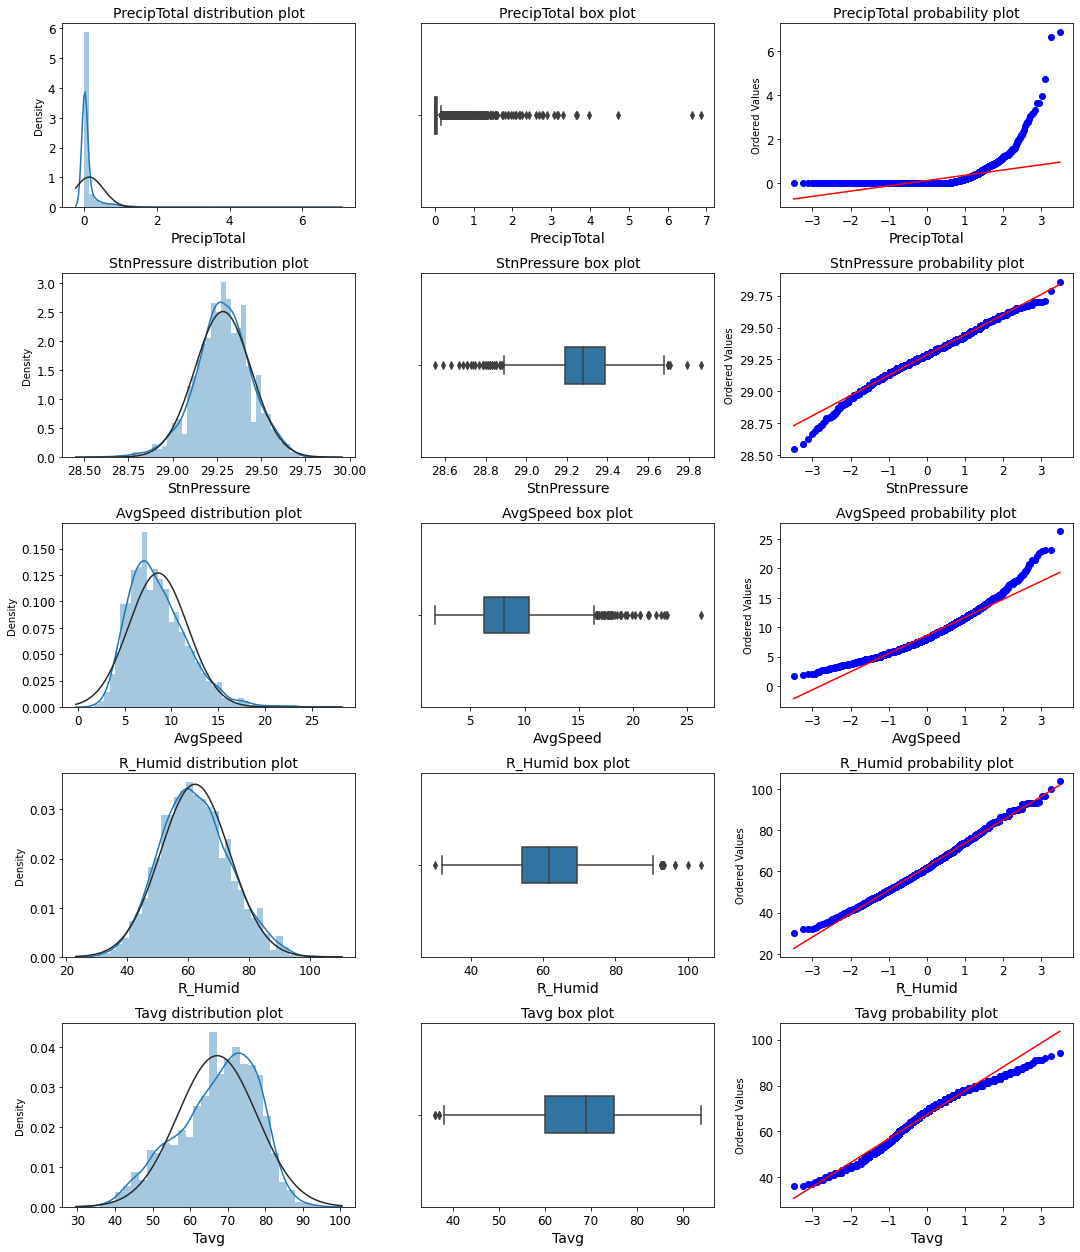

In [122]:
dist_plots(weather,['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'R_Humid',])

- `PrecipTotal` is highly skewed which infers that it has outliers
-`StnPressure` & `R_Humid` are generally normally distributed
- `AvgSpeed` & `Tavg` is slightly skewed. 

In [123]:
#create function to plot weather conditions
def create_grpby_plot(col, title, y_label):
    
    ax = weather.groupby(by=['Year', 'Month'])[col].sum().unstack(level=0).plot(xticks=weather['Month'], 
                                                                                        title=title)
    ax.set_xlabel('Month')
    ax.set_ylabel(y_label);

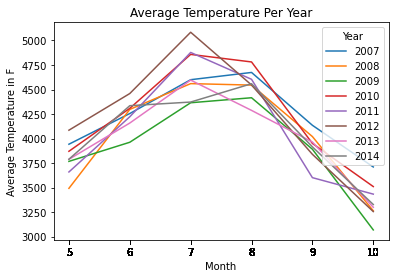

In [124]:
#visualisation for Tavg
create_grpby_plot(col='Tavg',
                  title='Average Temperature Per Year',
                  y_label='Average Temperature in F')

- The Average Temperature per years shows a similar pattern i.e. it starts low at the beginning of summer, increases and peaks around July, decreases August onwards. There are no abnormilities. 

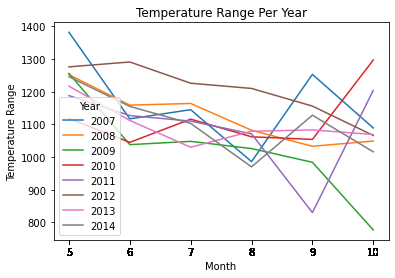

In [125]:
#visualising Temperature Range
create_grpby_plot(col='Trange',
                  title='Temperature Range Per Year',
                  y_label='Temperature Range')

- There is no clear pattern for temperature range throughout the years after August. However, I observed that the temperature range starts high in the beginning of summer and decreasing till Aug. 

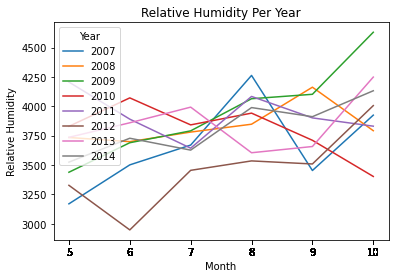

In [135]:
#Visualising Relative Humidity
create_grpby_plot(col='R_Humid',
                  title='Relative Humidity Per Year',
                  y_label='Relative Humidity')

- There are no clear pattern on relative humidity throughout the year.
- Without clear pattern, it would be hard to determine how relative himudy affects presence of WNV. 

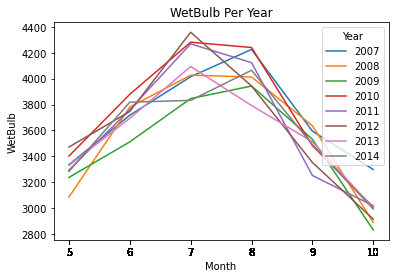

In [136]:
#Visualising WetBulb
create_grpby_plot(col='WetBulb',
                  title='WetBulb Per Year',
                  y_label='WetBulb')

- The WetBulb per years shows a similar pattern i.e. it starts low at the beginning of summer, increases and peaks around July, decreases August onwards. There are no abnormilities.  

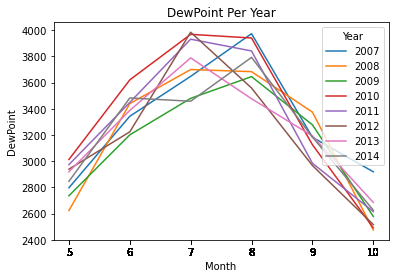

In [137]:
create_grpby_plot(col='DewPoint',
                  title='DewPoint Per Year',
                  y_label='DewPoint')

- The DewPoint per years shows a similar pattern i.e. it starts low at the beginning of summer, increases and peaks around July, decreases August onwards. There are no abnormilities.  

**WetDry**

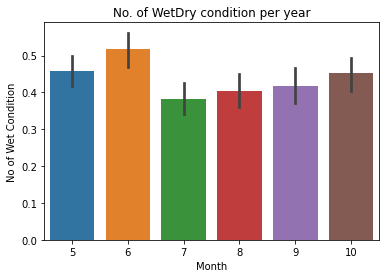

In [138]:
sns.barplot(data=weather, x="Month", y="WetDry")

#Plot data values for each bar

plt.title('No. of WetDry condition per year')
plt.xlabel('Month')
plt.ylabel('No of Wet Condition');

- There are no significant drops to the number of weather conditions between May to Oct. However, there are lesser wet condition in June than the rest of the months. 

#### Differences between Station 1 and Station 2

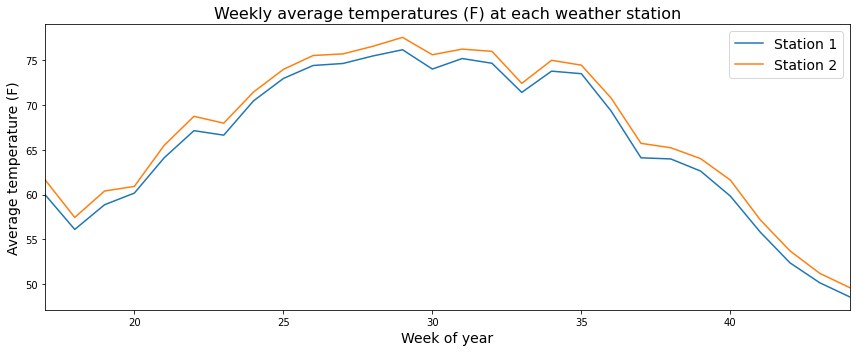

In [139]:
# plot weekly temperature by station
plt.figure(figsize=(12,5))
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather['Week'].min(), weather['Week'].max())
plt.tight_layout()

- The weekly reported Temperatures have the same pattern. However, Station 1 reported lower average temperature than Station 2

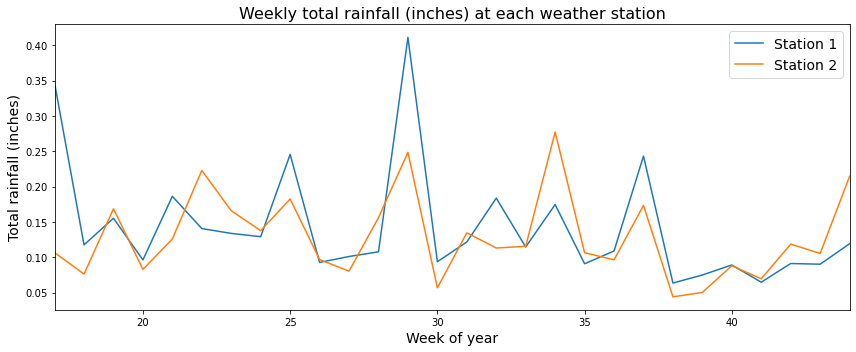

In [140]:
# plot weekly rainfall by station
plt.figure(figsize=(12,5))
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather['Week'].min(), weather['Week'].max())
plt.tight_layout()

- The weekly reported rainfall for both stations are similar in pattern, peaking around the same time of the week

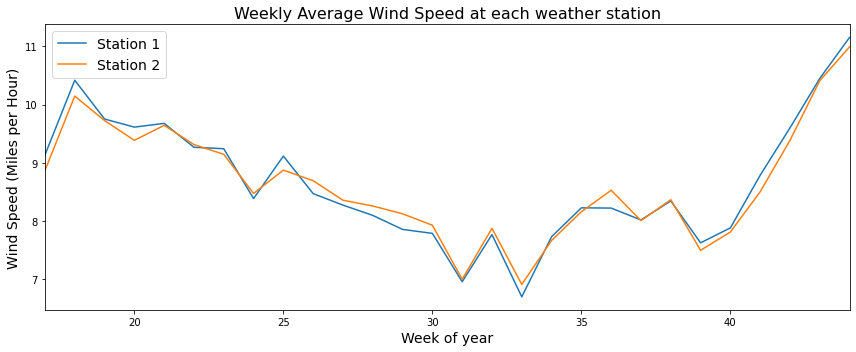

In [148]:
# plot weekly average windspeed by station
plt.figure(figsize=(12,5))
sns.lineplot(x = 'Week',y = 'AvgSpeed',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Week',y = 'AvgSpeed',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly Average Wind Speed at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Wind Speed (Miles per Hour)',fontsize=14)
plt.xlim(weather['Week'].min(), weather['Week'].max())
plt.tight_layout()

- The weekly reported wind speed for both stations are similar in pattern, peaking around the same time of the week

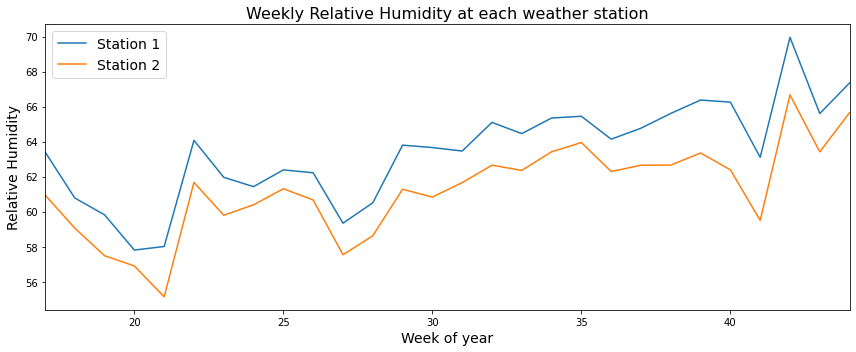

In [149]:
# plot weekly average windspeed by station
plt.figure(figsize=(12,5))
sns.lineplot(x = 'Week',y = 'R_Humid',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Week',y = 'R_Humid',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly Relative Humidity at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Relative Humidity',fontsize=14)
plt.xlim(weather['Week'].min(), weather['Week'].max())
plt.tight_layout()

- The weekly relative humidity for both stations are similar in pattern, peaking around the same time of the week

In [141]:
weather.shape

(2920, 23)

In [142]:
# Save weather to pickle file
weather.to_pickle('./data/weather_final.pkl')